# Classificador de AVC
 - A entrada será dados de vários pacientes
 - O modelo deve retornar se ele teve AVC ou não
 - Os dados estão disponíveis no Kaggle: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

## Passos:
 - Preparar dados para uso
   - Ler
   - Limpar
   - Separar
   - Normalizar
 - Plotar informações para ganhar insights
 - Utilizar um classificador
 - Criar um pipeline (opcional)
 - Utilizar validação cruzada



## Importando libs

In [481]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import time
from sklearn.model_selection    import (GridSearchCV,
                                        train_test_split,
                                        cross_val_score)
from sklearn.preprocessing      import LabelEncoder
from sklearn.preprocessing      import MinMaxScaler
from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score, 
                             roc_auc_score,
                             confusion_matrix,
                             classification_report,
                             roc_curve)
# model algorithms
from sklearn.ensemble           import (RandomForestClassifier, 
                                        AdaBoostClassifier, 
                                        GradientBoostingClassifier)
from sklearn.linear_model       import LogisticRegression
from sklearn.neighbors          import KNeighborsClassifier
from sklearn.tree               import DecisionTreeClassifier
from sklearn.svm                import SVC
from xgboost                    import XGBClassifier
from lightgbm                   import LGBMClassifier

from imblearn.over_sampling     import SMOTE

## Carregando e visualizando os dados

In [482]:
# Carregando os dados
df = pd.read_csv('./data/healthcare-dataset-stroke-data.csv', delimiter = ',', encoding = 'utf-8')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [483]:
# Non-Null ValueCounts and Feature Datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [484]:
# stats of numerical data
round (df.describe(exclude = 'object'), 2)

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.00,5110.00,5110.0,5110.00,5110.00,4909.00,5110.00
mean,36517.83,43.23,0.1,0.05,106.15,28.89,0.05
std,21161.72,22.61,0.3,0.23,45.28,7.85,0.22
min,67.00,0.08,0.0,0.00,55.12,10.30,0.00
25%,17741.25,25.00,0.0,0.00,77.24,23.50,0.00
50%,36932.00,45.00,0.0,0.00,91.88,28.10,0.00
75%,54682.00,61.00,0.0,0.00,114.09,33.10,0.00
max,72940.00,82.00,1.0,1.00,271.74,97.60,1.00


In [485]:
# stats of categorical data
round (df.describe(exclude = ['float', 'int64']),2)

,gender,ever_married,work_type,Residence_type,smoking_status
count,5110,5110,5110,5110,5110
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2925,2596,1892


## Plotando os dados para entender o problema e obter insights

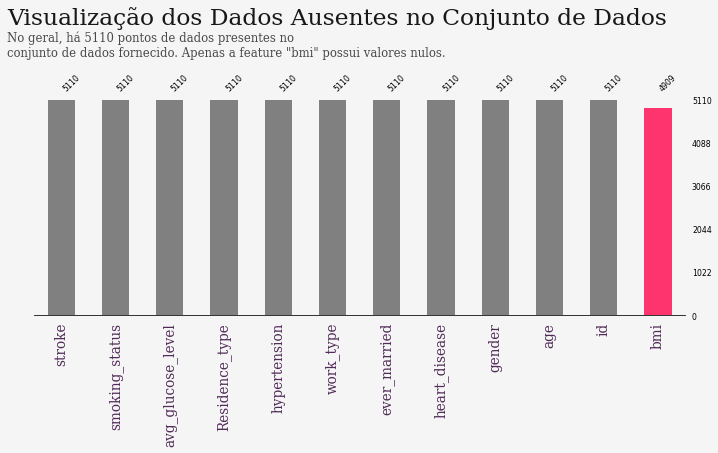

In [486]:
# Definindo cores personalizadas
color = ['grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', '#fe346e']

# Criando o gráfico de visualização de dados faltantes
fig, ax = plt.subplots(figsize=(12, 4), dpi=70)
fig.patch.set_facecolor('#f6f5f5')
ax.set_facecolor('#f6f5f5')

msno.bar(df, sort='descending', color=color, ax=ax, fontsize=8, labels='off', filter='top')

ax.text(-1, 1.35, 'Visualização dos Dados Ausentes no Conjunto de Dados', {'font': 'Serif', 'size': 24, 'color': 'black'}, alpha=0.9)
ax.text(-1, 1.2, 'No geral, há 5110 pontos de dados presentes no \nconjunto de dados fornecido. Apenas a feature "bmi" possui valores nulos.', {'font': 'Serif', 'size': 12, 'color': 'black'}, alpha=0.7)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center', **{'font': 'Serif', 'size': 14, 'weight': 'normal', 'color': '#512b58'}, alpha=1)
ax.set_yticklabels('')
ax.spines['bottom'].set_visible(True)

plt.show()

### Insights iniciais sobre o conjunto de dados

1. Faltam dados do atributo bmi.
2. Características categóricas e numéricas estão presentes.
     - **Atributos categóricos**: gênero, já casado, tipo de trabalho, tipo de residência, status de fumo
     - **Características Numéricas Binárias**: hipertensão, doença cardíaca, acidente vascular cerebral
     - **Características numéricas contínuas**: idade, avg_glucose_level, bmi
3. A maioria dos dados são categóricos e necessitam de uma atenção especial para visualizá-los.
4. A extração de atributos pode ser feita descartando os atributos contínuos (idade, nível de açúcar e IMC) e vamos manter tudo como está.

In [487]:
# handling missing values
df['bmi'] = df['bmi'].fillna(round (df['bmi'].median(), 2))
df.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

Apenas o atributo bmi possui alguns dados faltantes, que foram preenchidos com a mediana da mesma coluna. Para extração de recursos, a classificação foi aplicada para todos os valores contínuos, os valores de classificação são retirados dos seguintes artigos:


* [Classificação do índice de massa corporal](https://www.medicalnewstoday.com/articles/323446#body-mass-index)
* [Classificação de idade](https://kidspicturedictionary.com/english-through-pictures/people-english-through-pictures/age-physical-description/)
* [Classificação média de glicose](https://agamatrix.com/blog/normal-blood-sugar-level-chart/)

In [488]:
## binning of numerical variables

df['bmi_cat'] = pd.cut(df['bmi'], bins = [0, 19, 25, 30, 10000], labels = ['Underweight', 'Ideal', 'Overweight', 'Obesity'])
df['age_cat'] = pd.cut(df['age'], bins = [0, 13, 18, 45, 60, 200], labels = ['Children', 'Teens', 'Adults','Mid Adults','Elderly'])
df['glucose_cat'] = pd.cut(df['avg_glucose_level'], bins = [0, 90, 160, 230, 500], labels = ['Low', 'Normal', 'High', 'Very High'])

df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,bmi_cat,age_cat,glucose_cat
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,Obesity,Elderly,High
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,1,Overweight,Elderly,High
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,Obesity,Elderly,Normal
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,Obesity,Mid Adults,High
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,Ideal,Elderly,High


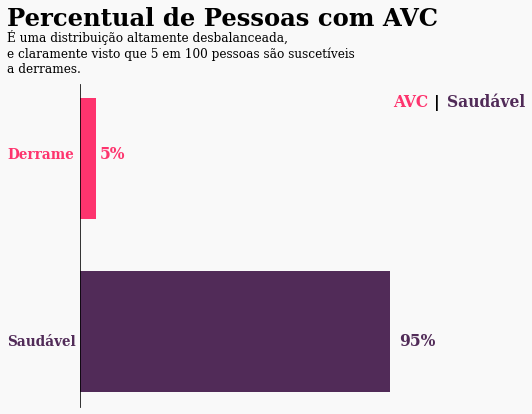

In [489]:
# Distribution of Targets

# Dados
x = pd.DataFrame(df.groupby(['stroke'])['stroke'].count())

# Plot
fig, ax = plt.subplots(figsize=(6, 6), dpi=70)
fig.patch.set_facecolor('#f9f9f9')
ax.set_facecolor('#f9f9f9')

ax.barh([1], x.stroke[1], height=0.7, color='#fe346e')
plt.text(-1150, -0.08, 'Saudável', {'font': 'Serif', 'weight': 'bold', 'size': 14, 'color': '#512b58'})
plt.text(5000, -0.08, '95%', {'font': 'Serif', 'weight': 'bold', 'size': 16, 'color': '#512b58'})
ax.barh([0], x.stroke[0], height=0.7, color='#512b58')
plt.text(-1150, 1, 'Derrame', {'font': 'Serif', 'weight': 'bold', 'size': 14, 'color': '#fe346e'})
plt.text(300, 1, '5%', {'font': 'Serif', 'weight': 'bold', 'size': 16, 'color': '#fe346e'})

plt.text(-1150, 1.77, 'Percentual de Pessoas com AVC', {'font': 'Serif', 'size': 25, 'weight': 'bold', 'color': 'black'})
plt.text(4900, 1.3, 'AVC', {'font': 'Serif', 'weight': 'bold', 'size': 16, 'weight': 'bold', 'color': '#fe346e'})
plt.text(5550, 1.3, '|', {'color': 'black', 'size': 16, 'weight': 'bold'})
plt.text(5750, 1.3, 'Saudável', {'font': 'Serif', 'weight': 'bold', 'size': 16, 'weight': 'bold', 'color': '#512b58'})
plt.text(-1150, 1.5, 'É uma distribuição altamente desbalanceada,\ne claramente visto que 5 em 100 pessoas são suscetíveis\na derrames.',
         {'font': 'Serif', 'size': 12.5, 'color': 'black'})

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


/tmp/ipykernel_5741/2349234256.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(labels=['Crianças', 'Adolescentes', 'Adultos', 'Adultos Médios', 'Idosos'],


Text(0.4, 1, 'AVCs e Idade')

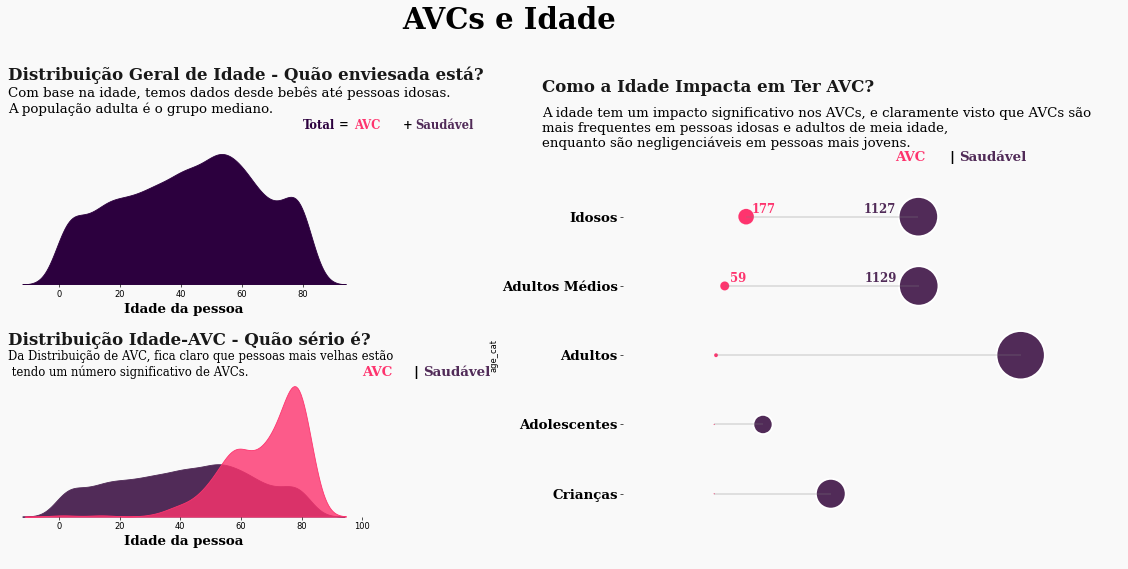

In [490]:
# Univariate analysis of continuous variables

# Plot
fig = plt.figure(figsize=(24, 10), dpi=60)

gs = fig.add_gridspec(10, 24)
gs.update(wspace=1, hspace=0.05)

ax2 = fig.add_subplot(gs[1:4, 0:8])    # Gráfico de distribuição
ax3 = fig.add_subplot(gs[6:9, 0:8])    # Gráfico de distribuição com matiz
ax1 = fig.add_subplot(gs[1:10, 13:])   # Gráfico dumbbell

# Lista de eixos
axes = [ax1, ax2, ax3]

# Configuração dos eixos; visibilidade dos eixos e espigões desligados
for ax in axes:
    ax.axes.get_yaxis().set_visible(False)
    ax.set_facecolor('#f9f9f9')
    
    for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)

fig.patch.set_facecolor('#f9f9f9')
        
ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(True)

# Gráfico dumbbell de pessoas com AVC e saudáveis

stroke_age = df[df['stroke'] == 1].age_cat.value_counts()
healthy_age = df[df['stroke'] == 0].age_cat.value_counts()

ax1.hlines(y=['Children', 'Teens', 'Adults', 'Mid Adults', 'Elderly'],
           xmin=[644, 270, 1691, 1129, 1127], 
           xmax=[1, 1, 11, 59, 177], color='grey', **{'linewidth': 0.5})

sns.scatterplot(y=stroke_age.index, x=stroke_age.values, s=stroke_age.values*2, color='#fe346e', ax=ax1, alpha=1)
sns.scatterplot(y=healthy_age.index, x=healthy_age.values, s=healthy_age.values*2, color='#512b58', ax=ax1, alpha=1)

ax1.axes.get_xaxis().set_visible(False)
ax1.set_xlim(xmin=-500, xmax=2250)
ax1.set_ylim(ymin=-1, ymax=5)

ax1.set_yticklabels(labels=['Crianças', 'Adolescentes', 'Adultos', 'Adultos Médios', 'Idosos'],
                     fontdict={'font': 'Serif', 'fontsize': 16, 'fontweight': 'bold', 'color': 'black'})

ax1.text(-950, 5.8, 'Como a Idade Impacta em Ter AVC?', {'font': 'Serif', 'size': 20, 'weight': 'bold', 'color': 'black'}, alpha=0.9)
ax1.text(1000, 4.8, 'AVC', {'font': 'Serif', 'weight': 'bold', 'size': '16', 'weight': 'bold', 'style': 'normal', 'color': '#fe346e'})
ax1.text(1300, 4.8, '|', {'color': 'black', 'size': '16', 'weight': 'bold'})
ax1.text(1350, 4.8, 'Saudável', {'font': 'Serif', 'weight': 'bold', 'size': '16', 'style': 'normal', 'weight': 'bold', 'color': '#512b58'})
ax1.text(-950, 5., 'A idade tem um impacto significativo nos AVCs, e claramente visto que AVCs são\nmais frequentes em pessoas idosas e adultos de meia idade,\nenquanto são negligenciáveis em pessoas mais jovens.',
         {'font': 'Serif', 'size': '16', 'color': 'black'})

ax1.text(stroke_age.values[0] + 30, 4.05, stroke_age.values[0], {'font': 'Serif', 'size': 14, 'weight': 'bold', 'color': '#fe346e'})
ax1.text(healthy_age.values[2] - 300, 4.05, healthy_age.values[2], {'font': 'Serif', 'size': 14, 'weight': 'bold', 'color': '#512b58'})

ax1.text(stroke_age.values[1] + 30, 3.05, stroke_age.values[1], {'font': 'Serif', 'size': 14, 'weight': 'bold', 'color': '#fe346e'})
ax1.text(healthy_age.values[1] - 300, 3.05, healthy_age.values[1], {'font': 'Serif', 'size': 14, 'weight': 'bold', 'color': '#512b58'})

# Gráficos de distribuição - apenas variável única

sns.kdeplot(data=df, x='age', ax=ax2, fill=True, color='#2c003e', alpha=1)
ax2.set_xlabel('Idade da pessoa', fontdict={'font': 'Serif', 'color': 'black', 'size': 16, 'weight': 'bold'})
ax2.text(-17, 0.025, 'Distribuição Geral de Idade - Quão enviesada está?', {'font': 'Serif', 'color': 'black', 'weight': 'bold', 'size': 20}, alpha=0.9)
ax2.text(-17, 0.021, 'Com base na idade, temos dados desde bebês até pessoas idosas.\nA população adulta é o grupo mediano.',
         {'font': 'Serif', 'size': '16', 'color': 'black'})
ax2.text(80, 0.019, 'Total', {'font': 'Serif', 'size': '14', 'color': '#2c003e', 'weight': 'bold'})
ax2.text(92, 0.019, '=', {'font': 'Serif', 'size': '14', 'color': 'black', 'weight': 'bold'})
ax2.text(97, 0.019, 'AVC', {'font': 'Serif', 'size': '14', 'color': '#fe346e', 'weight': 'bold'})
ax2.text(113, 0.019, '+', {'font': 'Serif', 'size': '14', 'color': 'black', 'weight': 'bold'})
ax2.text(117, 0.019, 'Saudável', {'font': 'Serif', 'size': '14', 'color': '#512b58', 'weight': 'bold'})

# Gráficos de distribuição com matiz de AVCs

sns.kdeplot(data=df[df['stroke'] == 0], x='age', ax=ax3, fill=True, alpha=1, color='#512b58')
sns.kdeplot(data=df[df['stroke'] == 1], x='age', ax=ax3, fill=True, alpha=0.8, color='#fe346e')

ax3.set_xlabel('Idade da pessoa', fontdict={'font': 'Serif', 'color': 'black', 'weight': 'bold', 'size': 16})

ax3.text(-17, 0.0525, 'Distribuição Idade-AVC - Quão sério é?', {'font': 'Serif', 'weight': 'bold', 'color': 'black', 'size': 20}, alpha=0.9)
ax3.text(-17, 0.043, 'Da Distribuição de AVC, fica claro que pessoas mais velhas estão\n tendo um número significativo de AVCs.', {'font': 'Serif', 'color': 'black', 'size': 14})
ax3.text(100, 0.043, 'AVC', {'font': 'Serif', 'weight': 'bold', 'size': '16', 'weight': 'bold', 'style': 'normal', 'color': '#fe346e'})
ax3.text(117, 0.043, '|', {'color': 'black', 'size': '16', 'weight': 'bold'})
ax3.text(120, 0.043, 'Saudável', {'font': 'Serif', 'weight': 'bold', 'size': '16', 'style': 'normal', 'weight': 'bold', 'color': '#512b58'})

fig.text(0.4, 1, 'AVCs e Idade', {'font': 'Serif', 'weight': 'bold', 'color': 'black', 'size': 35})


A idade é uma característica importante. A distribuição de características de idade não é uma distribuição normal, que precisa ser transformada posteriormente. A partir das características categóricas, pode-se observar que as pessoas idosas apresentam, mais casos de AVC, em comparação com as mais jovens.

/tmp/ipykernel_5741/3236600481.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(labels=['Baixo', 'Normal', 'Alto', 'Muito Alto'],
/tmp/ipykernel_5741/3236600481.py:93: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


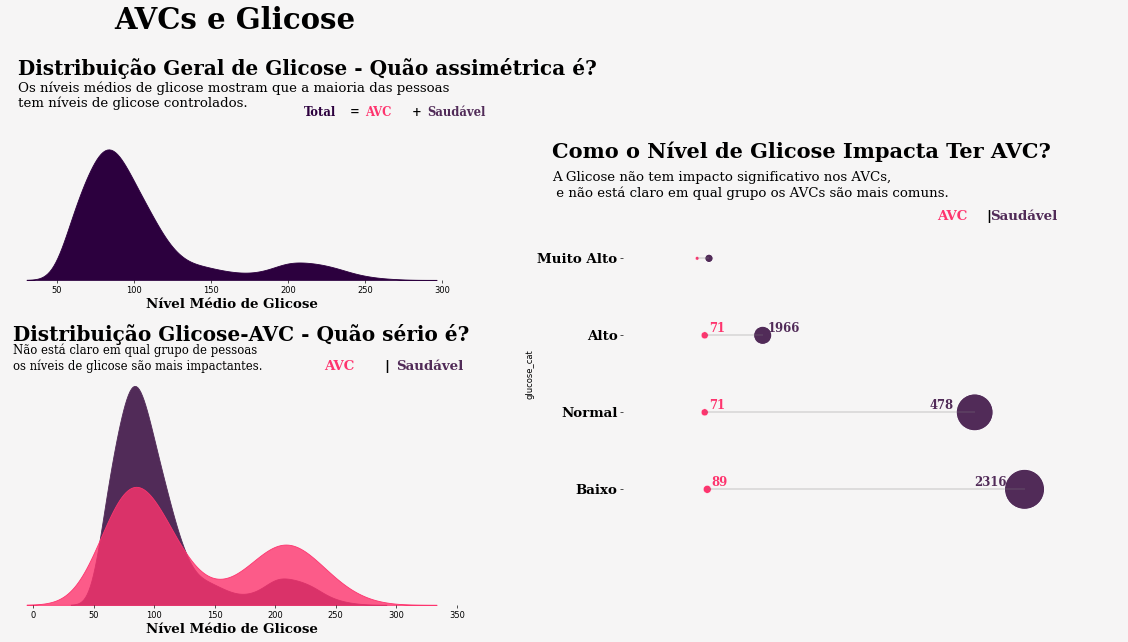

In [491]:
# Gráficos de distribuição de açúcar

fig = plt.figure(figsize=(24, 10), dpi=60)

gs = fig.add_gridspec(10, 24)
gs.update(wspace=1, hspace=0.05)

ax2 = fig.add_subplot(gs[0:3, 0:10])  # gráfico de distribuição
ax3 = fig.add_subplot(gs[5:10, 0:10])  # gráfico de distribuição de tonalidade
ax1 = fig.add_subplot(gs[0:, 13:])  # gráfico dumbbell

# lista de eixos
axes = [ax1, ax2, ax3]

# configuração dos eixos; desativar visibilidade dos eixos e espinhas
for ax in axes:
    ax.axes.get_yaxis().set_visible(False)
    ax.set_facecolor('#f6f5f5')

    for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)

fig.patch.set_facecolor('#f6f5f5')

ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(True)

# gráfico dumbbell de pessoas com AVC e saudáveis

stroke_glu = df[df['stroke'] == 1].glucose_cat.value_counts()
healthy_glu = df[df['stroke'] == 0].glucose_cat.value_counts()

ax1.hlines(y=['Low', 'Normal', 'High', 'Very High'], xmin=[2316, 1966, 478, 101],
           xmax=[89, 71, 71, 18], color='grey', **{'linewidth': 0.5})

sns.scatterplot(y=stroke_glu.index, x=stroke_glu.values, s=stroke_glu.values, color='#fe346e', ax=ax1, alpha=1)
sns.scatterplot(y=healthy_glu.index, x=healthy_glu.values, s=healthy_glu.values, color='#512b58', ax=ax1, alpha=1)

ax1.axes.get_xaxis().set_visible(False)
ax1.set_xlim(xmin=-500, xmax=3000)
ax1.set_ylim(ymin=-1.5, ymax=4.5)

ax1.set_yticklabels(labels=['Baixo', 'Normal', 'Alto', 'Muito Alto'],
                     fontdict={'font': 'Serif', 'fontsize': 16, 'fontweight': 'bold', 'color': 'black'})

ax1.text(-1000, 4.3, 'Como o Nível de Glicose Impacta Ter AVC?', {'font': 'Serif', 'size': '25', 'weight': 'bold', 'color': 'black'})
ax1.text(1700, 3.5, 'AVC ', {'font': 'Serif', 'weight': 'bold', 'size': '16', 'weight': 'bold', 'style': 'normal', 'color': '#fe346e'})
ax1.text(2050, 3.5, '|', {'color': 'black', 'size': '16', 'weight': 'bold'})
ax1.text(2075, 3.5, 'Saudável', {'font': 'Serif', 'weight': 'bold', 'size': '16', 'style': 'normal', 'weight': 'bold', 'color': '#512b58'})
ax1.text(-1000, 3.8, 'A Glicose não tem impacto significativo nos AVCs,\n e não está claro em qual grupo os AVCs são mais comuns.', 
         {'font': 'Serif', 'size': '16', 'color': 'black'})

ax1.text(stroke_glu.values[0] + 30, 0.05, stroke_glu.values[0], {'font': 'Serif', 'size': 14, 'weight': 'bold', 'color': '#fe346e'})
ax1.text(healthy_glu.values[0] + -355, 0.05, healthy_glu.values[0], {'font': 'Serif', 'size': 14, 'weight': 'bold', 'color': '#512b58'})

ax1.text(stroke_glu.values[2] + 30, 1.05, stroke_glu.values[2], {'font': 'Serif', 'size': 14, 'weight': 'bold', 'color': '#fe346e'})
ax1.text(healthy_glu.values[2] + 1170, 1.05, healthy_glu.values[2], {'font': 'Serif', 'size': 14, 'weight': 'bold', 'color': '#512b58'})

ax1.text(stroke_glu.values[1] + 30, 2.05, stroke_glu.values[1], {'font': 'Serif', 'size': 14, 'weight': 'bold', 'color': '#fe346e'})
ax1.text(healthy_glu.values[1] - 1450, 2.05, healthy_glu.values[1], {'font': 'Serif', 'size': 14, 'weight': 'bold', 'color': '#512b58'})


# gráficos de distribuição ---- apenas variável única

sns.kdeplot(data=df, x='avg_glucose_level', ax=ax2, fill=True, color='#2c003e', alpha=1, )
ax2.set_xlabel('Nível Médio de Glicose', fontdict={'font': 'Serif', 'color': 'black', 'size': 16, 'weight': 'bold'})
ax2.text(25, 0.025, 'Distribuição Geral de Glicose - Quão assimétrica é?', {'font': 'Serif', 'color': 'black', 'weight': 'bold', 'size': 24})
ax2.text(25, 0.021, 'Os níveis médios de glicose mostram que a maioria das pessoas \ntem níveis de glicose controlados.', 
         {'font': 'Serif', 'size': '16', 'color': 'black'})
ax2.text(210, 0.020, 'Total', {'font': 'Serif', 'size': '14', 'color': '#2c003e', 'weight': 'bold'})
ax2.text(240, 0.02, '=', {'font': 'Serif', 'size': '14', 'color': 'black', 'weight': 'bold'})
ax2.text(250, 0.02, 'AVC', {'font': 'Serif', 'size': '14', 'color': '#fe346e', 'weight': 'bold'})
ax2.text(280, 0.02, '+', {'font': 'Serif', 'size': '14', 'color': 'black', 'weight': 'bold'})
ax2.text(290, 0.02, 'Saudável', {'font': 'Serif', 'size': '14', 'color': '#512b58', 'weight': 'bold'})


# gráficos de distribuição de AVC

sns.kdeplot(data=df[df['stroke'] == 0], x='avg_glucose_level', ax=ax3, fill=True, alpha=1, color='#512b58')
sns.kdeplot(data=df[df['stroke'] == 1], x='avg_glucose_level', ax=ax3, fill=True, alpha=0.8, color='#fe346e')

ax3.set_xlabel('Nível Médio de Glicose', fontdict={'font': 'Serif', 'color': 'black', 'weight': 'bold', 'size': 16})

ax3.text(-17, 0.0195, 'Distribuição Glicose-AVC - Quão sério é?', {'font': 'Serif', 'weight': 'bold', 'color': 'black', 'size': 24})
ax3.text(-17, 0.0174, 'Não está claro em qual grupo de pessoas \nos níveis de glicose são mais impactantes.', {'font': 'Serif', 'color': 'black', 'size': 14})
ax3.text(240, 0.0174, 'AVC', {'font': 'Serif', 'weight': 'bold', 'size': '16', 'weight': 'bold', 'style': 'normal', 'color': '#fe346e'})
ax3.text(290, 0.0174, '|', {'color': 'black', 'size': '16', 'weight': 'bold'})
ax3.text(300, 0.0174, 'Saudável', {'font': 'Serif', 'weight': 'bold', 'size': '16', 'style': 'normal', 'weight': 'bold', 'color': '#512b58'})


fig.text(0.2, 1.07, 'AVCs e Glicose', {'font': 'Serif', 'weight': 'bold', 'color': 'black', 'size': 35})

fig.show()


A distribuição do nível de glicose é distorcida para a esquerda e a pode se observar que não há muita relação entre AVCs e níveis de açucar no sangue.

/tmp/ipykernel_5741/4092215240.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(labels=['Obesidade', 'Sobrepeso', 'Ideal', 'Abaixo do Peso'],
/tmp/ipykernel_5741/4092215240.py:85: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


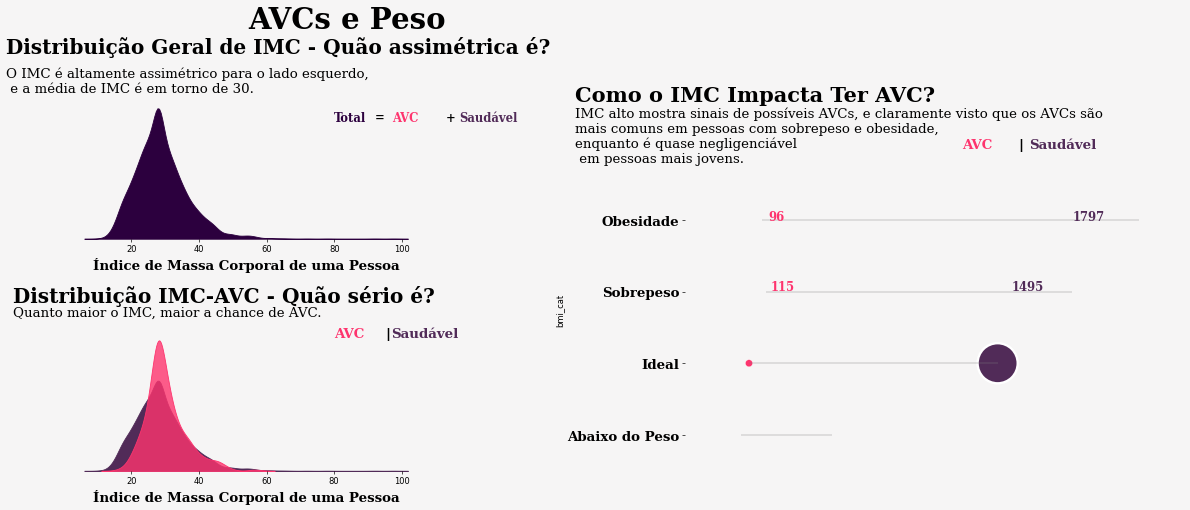

In [492]:
fig = plt.figure(figsize=(24, 10), dpi=60)

gs = fig.add_gridspec(10, 24)
gs.update(wspace=1, hspace=0.05)

ax2 = fig.add_subplot(gs[1:4, 0:8])  # gráfico de distribuição
ax3 = fig.add_subplot(gs[6:9, 0:8])  # gráfico de distribuição de tonalidade
ax1 = fig.add_subplot(gs[2:9, 13:])  # gráfico dumbbell

# lista de eixos
axes = [ax1, ax2, ax3]

# configuração dos eixos; desativar visibilidade dos eixos e espinhas
for ax in axes:
    ax.axes.get_yaxis().set_visible(False)
    ax.set_facecolor('#f6f5f5')

    for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)

fig.patch.set_facecolor('#f6f5f5')

ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(True)
ax1.set_xlim(xmin=-250, xmax=2000)
ax1.set_ylim(ymin=-1, ymax=3.5)

# gráfico dumbbell de pessoas com AVC e saudáveis

stroke_bmi = df[df['stroke'] == 1].bmi_cat.value_counts()
healthy_bmi = df[df['stroke'] == 0].bmi_cat.value_counts()

ax1.hlines(y=['Obesidade', 'Sobrepeso', 'Ideal', 'Abaixo do Peso'], xmin=[96, 115, 37, 1],
           xmax=[1797, 1495, 1159, 410], color='grey', **{'linewidth': 0.5})

sns.scatterplot(y=stroke_bmi.index, x=stroke_bmi.values, s=stroke_bmi.values*2, color='#fe346e', ax=ax1, alpha=1)
sns.scatterplot(y=healthy_bmi.index, x=healthy_bmi.values, s=healthy_bmi.values*2, color='#512b58', ax=ax1, alpha=1)

ax1.set_yticklabels(labels=['Obesidade', 'Sobrepeso', 'Ideal', 'Abaixo do Peso'],
                     fontdict={'font': 'Serif', 'fontsize': 16, 'fontweight': 'bold', 'color': 'black'})

ax1.text(-750, -1.65, 'Como o IMC Impacta Ter AVC?', {'font': 'Serif', 'size': '25', 'weight': 'bold', 'color': 'black'})
ax1.text(1000, -1., 'AVC ', {'font': 'Serif', 'weight': 'bold', 'size': '16', 'weight': 'bold', 'style': 'normal', 'color': '#fe346e'})
ax1.text(1250, -1, '|', {'color': 'black', 'size': '16', 'weight': 'bold'})
ax1.text(1300, -1, 'Saudável', {'font': 'Serif', 'weight': 'bold', 'size': '16', 'style': 'normal', 'weight': 'bold', 'color': '#512b58'})
ax1.text(-750, -0.8, 'IMC alto mostra sinais de possíveis AVCs, e claramente visto que os AVCs são \nmais comuns em pessoas com sobrepeso e obesidade, \nenquanto é quase negligenciável\n em pessoas mais jovens.', 
         {'font': 'Serif', 'size': '16', 'color': 'black'})

ax1.text(stroke_bmi.values[0] + 20 , 0.98, stroke_bmi.values[0], {'font':'Serif', 'size':14, 'weight':'bold', 'color':'#fe346e'})
ax1.text(healthy_bmi.values[1] - 275 ,0.98, healthy_bmi.values[1], {'font':'Serif', 'size':14, 'weight':'bold', 'color':'#512b58'})

ax1.text(stroke_bmi.values[1] + 30,0, stroke_bmi.values[1], {'font':'Serif', 'size':14, 'weight':'bold', 'color':'#fe346e'})
ax1.text(healthy_bmi.values[0] - 300,0, healthy_bmi.values[0], {'font':'Serif', 'size':14, 'weight':'bold', 'color':'#512b58'})


# gráficos de distribuição ---- apenas variável única

sns.kdeplot(data=df, x='bmi', ax=ax2, fill=True, color='#2c003e', alpha=1, )
ax2.set_xlabel('Índice de Massa Corporal de uma Pessoa', fontdict={'font': 'Serif', 'color': 'black', 'size': 16, 'weight': 'bold'})
ax2.text(-17, 0.095, 'Distribuição Geral de IMC - Quão assimétrica é?', {'font': 'Serif', 'color': 'black', 'weight': 'bold', 'size': 24})
ax2.text(-17, 0.075, 'O IMC é altamente assimétrico para o lado esquerdo,\n e a média de IMC é em torno de 30.', 
         {'font': 'Serif', 'size': '16', 'color': 'black'})
ax2.text(80, 0.06, 'Total', {'font': 'Serif', 'size': '14', 'color': '#2c003e', 'weight': 'bold'})
ax2.text(92, 0.06, '=', {'font': 'Serif', 'size': '14', 'color': 'black', 'weight': 'bold'})
ax2.text(97, 0.06, 'AVC', {'font': 'Serif', 'size': '14', 'color': '#fe346e', 'weight': 'bold'})
ax2.text(113, 0.06, '+', {'font': 'Serif', 'size': '14', 'color': 'black', 'weight': 'bold'})
ax2.text(117, 0.06, 'Saudável', {'font': 'Serif', 'size': '14', 'color': '#512b58', 'weight': 'bold'})


# gráficos de distribuição com tonalidade de AVC

sns.kdeplot(data=df[df['stroke'] == 0], x='bmi', ax=ax3, fill=True, alpha=1, color='#512b58')
sns.kdeplot(data=df[df['stroke'] == 1], x='bmi', ax=ax3, fill=True, alpha=0.8, color='#fe346e')

ax3.set_xlabel('Índice de Massa Corporal de uma Pessoa', fontdict={'font': 'Serif', 'color': 'black', 'weight': 'bold', 'size': 16})

ax3.text(-15, 0.12, 'Distribuição IMC-AVC - Quão sério é?', {'font': 'Serif', 'weight': 'bold', 'color': 'black', 'size': 24})
ax3.text(-15, 0.11, 'Quanto maior o IMC, maior a chance de AVC.', {'font': 'Serif', 'color': 'black', 'size': 16})
ax3.text(80, 0.095, 'AVC ', {'font': 'Serif', 'weight': 'bold', 'size': '16', 'weight': 'bold', 'style': 'normal', 'color': '#fe346e'})
ax3.text(95, 0.095, '|', {'color': 'black', 'size': '16', 'weight': 'bold'})
ax3.text(97, 0.095, 'Saudável', {'font': 'Serif', 'weight': 'bold', 'size': '16', 'style': 'normal', 'weight': 'bold', 'color': '#512b58'})

fig.text(0.25, 0.925, 'AVCs e Peso', {'font': 'Serif', 'weight': 'bold', 'color': 'black', 'size': 35})

fig.show()


O IMC é altamente distorcido para à esquerda, e o IMC alto, indica grande possibilidade de sofrer derrames.

/tmp/ipykernel_5741/1840300411.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(stroke_gen.index, **font_dict)
/tmp/ipykernel_5741/1840300411.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(['Privado', 'Autônomo', 'Crianças', 'P/ Governo', 'N trabalhou'], **font_dict)
/tmp/ipykernel_5741/1840300411.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(['Sim', 'Não'], **font_dict)
/tmp/ipykernel_5741/1840300411.py:85: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(['Sim', 'Não'], **font_dict)
/tmp/ipykernel_5741/1840300411.py:98: UserWarning: set_ticklabels() should only 

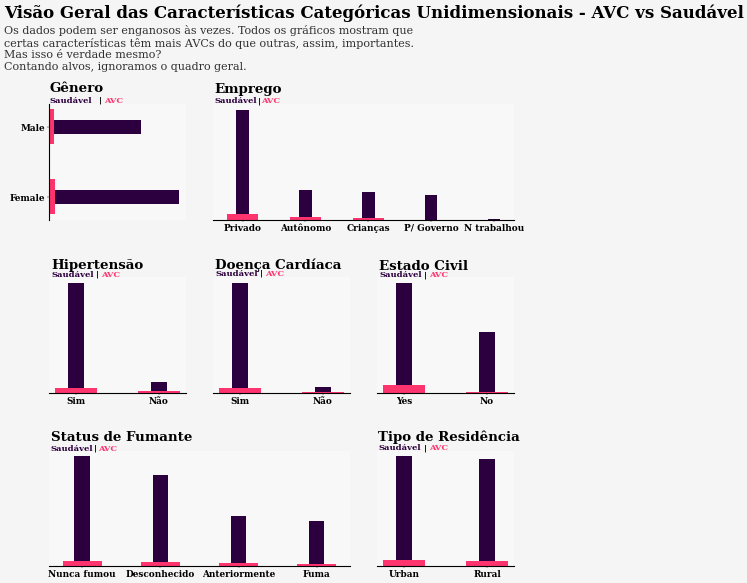

In [493]:
fig = plt.figure(figsize=(15, 15), dpi=40)

gs = fig.add_gridspec(3, 3)
gs.update(wspace=0.2, hspace=0.5)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1:])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[1, 2])
ax6 = fig.add_subplot(gs[2, 0:2])
ax7 = fig.add_subplot(gs[2, 2])

axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]

fig.patch.set_facecolor('#f5f5f5')

# setting of axes; visibility of axes and spines turn off
for ax in axes:
    ax.axes.get_yaxis().set_visible(False)
    ax.set_facecolor('#f8f8f8')
    ax.spines['bottom'].set_linewidth(2)
    for loc in ['left', 'right', 'top']:
        ax.spines[loc].set_visible(False)
        ax.spines[loc].set_linewidth(2)

title_args = {'font': 'Serif', 'weight': 'bold', 'color': 'black', 'size': 24}
font_dict = {'size': 16, 'family': 'Serif', 'color': 'black', 'weight': 'bold'}
health_dict = {'font': 'Serif', 'color': '#2c003e', 'size': 15, 'weight': 'bold'}
dash_dict = {'font': 'Serif', 'color': 'black', 'size': 15, 'weight': 'bold'}
stroke_dict = {'font': 'Serif', 'color': '#fe346e', 'size': 15, 'weight': 'bold'}

stroke_col = '#fe346e'
healthy_col = '#2c003e'

# Ax1: Distribuições de gênero - AVC
healthy_gen = df[df['stroke'] == 0].gender.value_counts()
stroke_gen = df[df['stroke'] == 1].gender.value_counts()

ax1.barh(stroke_gen.index, width=healthy_gen.values[0:2], height=0.2, color=healthy_col)
ax1.barh(np.arange(len(stroke_gen.index)), width=stroke_gen.values, height=0.5, color=stroke_col)
ax1.set_yticklabels(stroke_gen.index, **font_dict)

ax1.axes.get_yaxis().set_visible(True)
ax1.axes.get_xaxis().set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(True)
ax1.text(0, 1.5, 'Gênero', **title_args)
ax1.text(0, 1.35, 'Saudável', **health_dict)
ax1.text(1100, 1.35, '|', **dash_dict)
ax1.text(1200, 1.35, 'AVC', **stroke_dict)

# Ax2: Distribuições de trabalho - AVC
healthy_gen = df[df['stroke'] == 0].work_type.value_counts()
stroke_gen = df[df['stroke'] == 1].work_type.value_counts()

ax2.bar(healthy_gen.index, height=healthy_gen.values, width=0.2, color=healthy_col)
ax2.bar(np.arange(len(stroke_gen.index)), height=stroke_gen.values, width=0.5, color=stroke_col)
ax2.set_xticklabels(['Privado', 'Autônomo', 'Crianças', 'P/ Governo', 'N trabalhou'], **font_dict)

ax2.text(-0.45, 3200, 'Emprego', **title_args)
ax2.text(-0.45, 2950, 'Saudável', **health_dict)
ax2.text(0.24, 2950, '|', **dash_dict)
ax2.text(0.30, 2950, 'AVC', **stroke_dict)

# Ax3: Distribuições de hipertensão - AVC
healthy_gen = df[df['stroke'] == 0].hypertension.value_counts()
stroke_gen = df[df['stroke'] == 1].hypertension.value_counts()

ax3.bar(['Sim', 'Não'], height=healthy_gen.values, width=0.2, color=healthy_col)
ax3.bar(stroke_gen.index, height=stroke_gen.values, width=0.5, color=stroke_col)
ax3.set_xticklabels(['Sim', 'Não'], **font_dict)

ax3.text(-0.3, 5000, 'Hipertensão', **title_args)
ax3.text(-0.3, 4700, 'Saudável', **health_dict)
ax3.text(0.24, 4700, '|', **dash_dict)
ax3.text(0.30, 4700, 'AVC', **stroke_dict)

# Ax4: Distribuições de doença cardíaca - AVC
healthy_gen = df[df['stroke'] == 0].heart_disease.value_counts()
stroke_gen = df[df['stroke'] == 1].heart_disease.value_counts()

ax4.bar(['Sim', 'Não'], height=healthy_gen.values, width=0.2, color=healthy_col)
ax4.bar(stroke_gen.index, height=stroke_gen.values, width=0.5, color=stroke_col)
ax4.set_xticklabels(['Sim', 'Não'], **font_dict)

ax4.text(-0.3, 5250, 'Doença Cardíaca', **title_args)
ax4.text(-0.3, 4950, 'Saudável', **health_dict)
ax4.text(0.24, 4950, '|', **dash_dict)
ax4.text(0.30, 4950, 'AVC', **stroke_dict)

# Ax5: Distribuições de casamento - AVC
healthy_gen = df[df['stroke'] == 0].ever_married.value_counts()
stroke_gen = df[df['stroke'] == 1].ever_married.value_counts()

ax5.bar(healthy_gen.index, height=healthy_gen.values, width=0.2, color=healthy_col)
ax5.bar(np.arange(len(stroke_gen.index)), height=stroke_gen.values, width=0.5, color=stroke_col)
ax5.set_xticklabels(healthy_gen.index, **font_dict)

ax5.text(-0.3, 3500, 'Estado Civil', **title_args)
ax5.text(-0.3, 3300, 'Saudável', **health_dict)
ax5.text(0.24, 3300, '|', **dash_dict)
ax5.text(0.30, 3300, 'AVC', **stroke_dict)

# Ax6: Distribuições de status de fumante - AVC
healthy_gen = df[df['stroke'] == 0].smoking_status.value_counts()
stroke_gen = df[df['stroke'] == 1].smoking_status.value_counts()

ax6.bar(healthy_gen.index, height=healthy_gen.values, width=0.2, color=healthy_col)
ax6.bar(np.arange(len(stroke_gen.index)), height=stroke_gen.values, width=0.5, color=stroke_col)
ax6.set_xticklabels(['Nunca fumou', 'Desconhecido', 'Anteriormente', 'Fuma'], **font_dict)

ax6.text(-0.4, 2050, 'Status de Fumante', **title_args)
ax6.text(-0.4, 1900, 'Saudável', **health_dict)
ax6.text(0.15, 1900, '|', **dash_dict)
ax6.text(0.20, 1900, 'AVC', **stroke_dict)

# Ax7: Distribuições de tipo de residência - AVC
healthy_gen = df[df['stroke'] == 0].Residence_type.value_counts()
stroke_gen = df[df['stroke'] == 1].Residence_type.value_counts()

ax7.bar(healthy_gen.index, height=healthy_gen.values, width=0.2, color=healthy_col)
ax7.bar(np.arange(len(stroke_gen.index)), height=stroke_gen.values, width=0.5, color=stroke_col)
ax7.set_xticklabels(healthy_gen.index, **font_dict)

ax7.text(-0.31, 2800, 'Tipo de Residência ', **title_args)
ax7.text(-0.31, 2600, 'Saudável', **health_dict)
ax7.text(0.24, 2600, '|', **dash_dict)
ax7.text(0.30, 2600, 'AVC', **stroke_dict)

fig.text(0.05, 1.025, 'Visão Geral das Características Categóricas Unidimensionais - AVC vs Saudável', {'font': 'Serif', 'color': 'black', 'size': 30, 'weight': 'bold'})
fig.text(0.05, 0.9375, 'Os dados podem ser enganosos às vezes. Todos os gráficos mostram que\ncertas características têm mais AVCs do que outras, assim, importantes. \nMas isso é verdade mesmo? \nContando alvos, ignoramos o quadro geral.', {'font': 'Serif', 'color': 'black', 'size': 20, 'weight': 'normal'}, alpha=0.8)

fig.show()

A visão geral dos recursos categóricos mostra as contagens de valores para cada recurso categórico. Esta visão geral pode fornecer algumas dicas sobre onde os acidentes vasculares cerebrais são numerosos. É importante enfatizar que nem sempre essas dados podem ter relações e as vezes podem ser mera coincidência, assim, exige atenção e cuidado na análise.

## Modelagem e Resultados

In [494]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,bmi_cat,age_cat,glucose_cat
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,Obesity,Elderly,High
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,1,Overweight,Elderly,High
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,Obesity,Elderly,Normal
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,Obesity,Mid Adults,High
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,Ideal,Elderly,High


### Pré processamento dos dados

A função `get_dummies` do `pandas` cria colunas para cada valor único em uma variável categórica.
Ou seja, se uma variável categórica tiver mais de duas categorias, cada categoria será representada por uma coluna binária separada. Por exemplo,  se a variável *work_type* tiver as categorias *Private*, *Self-employed*, *Govt_job* e *children*, a codificação  *one-hot* criará quatro novas colunas binárias, uma para cada categoria.

In [495]:
# separando os tipos de cada coluna
ordinal = ['age_cat', 'glucose_cat', 'bmi_cat', 'hypertension', 'heart_disease']        # label enconding
nominal =  ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'] 
numerical = ['age','bmi', 'avg_glucose_level'] 

# pré-processamento - codificação de atributos ordianais e escala de valor numérico
mms = MinMaxScaler()    # Usado para transformar recursos numéricos dimensionando cada recurso para o intervalo de 0 a 1 (normalização)
le = LabelEncoder()     # Usado para codificar rótulos de destino com valor entre 0 e n_classes - 1

# Separando entrada de saida, tirando o id pq ele nao é um atributo que impacta em ter ou não AVC
X = df.drop(['stroke', 'id'], axis = 1)
y = df['stroke']

## codificação de rótulos de recursos categóricos ordinais
for col in ordinal:
    X[col] = le.fit_transform(X[col])

X

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,bmi_cat,age_cat,glucose_cat
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,2,0
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,2,2,0
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,2,2
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,3,0
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,28.1,never smoked,2,2,1
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,1,2,2
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,1,0,1
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,2,3,0


In [496]:
## normalizando recursos numéricos - Valores ficam entre 0 e 1
X[numerical] = mms.fit_transform(X[numerical])

X

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,bmi_cat,age_cat,glucose_cat
0,Male,0.816895,0,1,Yes,Private,Urban,0.801265,0.301260,formerly smoked,1,2,0
1,Female,0.743652,0,0,Yes,Self-employed,Rural,0.679023,0.203895,never smoked,2,2,0
2,Male,0.975586,0,1,Yes,Private,Rural,0.234512,0.254296,never smoked,1,2,2
3,Female,0.597168,0,0,Yes,Private,Urban,0.536008,0.276060,smokes,1,3,0
4,Female,0.963379,1,0,Yes,Self-employed,Rural,0.549349,0.156930,never smoked,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,0.975586,1,0,Yes,Private,Urban,0.132167,0.203895,never smoked,2,2,1
5106,Female,0.987793,0,0,Yes,Self-employed,Urban,0.323516,0.340206,never smoked,1,2,2
5107,Female,0.426270,0,0,Yes,Self-employed,Rural,0.128658,0.232532,never smoked,1,0,1
5108,Male,0.621582,0,0,Yes,Private,Rural,0.513203,0.175258,formerly smoked,2,3,0


In [497]:
# tratando dados categoricos com a funcao get_dummies como descrito anteriormente
temp = X.drop(columns = nominal)
dummies = pd.get_dummies(X[nominal])
X = pd.concat([temp,dummies], axis = 1)

X

,age,hypertension,heart_disease,avg_glucose_level,bmi,bmi_cat,age_cat,glucose_cat,gender_Female,gender_Male,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0.816895,0,1,0.801265,0.301260,1,2,0,False,True,...,False,True,False,False,False,True,False,True,False,False
1,0.743652,0,0,0.679023,0.203895,2,2,0,True,False,...,False,False,True,False,True,False,False,False,True,False
2,0.975586,0,1,0.234512,0.254296,1,2,2,False,True,...,False,True,False,False,True,False,False,False,True,False
3,0.597168,0,0,0.536008,0.276060,1,3,0,True,False,...,False,True,False,False,False,True,False,False,False,True
4,0.963379,1,0,0.549349,0.156930,0,2,0,True,False,...,False,False,True,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,0.975586,1,0,0.132167,0.203895,2,2,1,True,False,...,False,True,False,False,False,True,False,False,True,False
5106,0.987793,0,0,0.323516,0.340206,1,2,2,True,False,...,False,False,True,False,False,True,False,False,True,False
5107,0.426270,0,0,0.128658,0.232532,1,0,1,True,False,...,False,False,True,False,True,False,False,False,True,False
5108,0.621582,0,0,0.513203,0.175258,2,3,0,False,True,...,False,True,False,False,True,False,False,True,False,False


A função `train_test_split` divide o nosso `DataFrame` em subconjuntos "aleatórios" (baseado na semente *random_state* passada como parâmetro), de treinamento e teste.

In [498]:
# divisão de dados de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, shuffle = True, random_state = 32)

print('Shape of Training features: {}'.format(X_train.shape))
print('Shape of Training targets: {}'.format(y_train.shape))
print('Shape of Testing features: {}'.format(X_test.shape))
print('Shape of Testing targets: {}'.format(y_test.shape))

Shape of Training features: (3832, 24)
Shape of Training targets: (3832,)
Shape of Testing features: (1278, 24)
Shape of Testing targets: (1278,)


A função `SMOTE()` é usada para realizar oversampling em conjuntos de dados desbalanceados, como é o nosso caso, em que temos apenas 5% dos casos indicando AVC. SMOTE significa *Synthetic Minority Over-sampling Technique*. Basicamente ele ajuda a criar novas amostras sintéticas da classe minoritária para equilibrar a distribuição das classes. Ao equilibrar as classes, o SMOTE ajuda a reduzir o viés de classificação que pode ocorrer quando há classes muito desbalanceadas.

In [499]:
smote = SMOTE()
X_resample, y_resample = smote.fit_resample(X_train, y_train.ravel())

print('Shape of Training features: {}'.format(X_resample.shape))
print('Shape of Training targets: {}'.format(y_resample.shape))
print('Shape of Testing features: {}'.format(X_test.shape))
print('Shape of Testing targets: {}'.format(y_test.shape))

Shape of Training features: (7292, 24)
Shape of Training targets: (7292,)
Shape of Testing features: (1278, 24)
Shape of Testing targets: (1278,)


/tmp/ipykernel_5741/1986260987.py:2: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  X_resample, y_resample = smote.fit_resample(X_train, y_train.ravel())


In [500]:
X_resample

,age,hypertension,heart_disease,avg_glucose_level,bmi,bmi_cat,age_cat,glucose_cat,gender_Female,gender_Male,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0.475098,1,0,0.013711,0.331042,1,0,1,True,False,...,False,True,False,False,True,False,False,False,False,True
1,0.487305,0,0,0.273290,0.206186,2,0,2,True,False,...,False,False,False,False,False,True,False,False,False,True
2,0.511719,0,0,0.130597,0.172967,2,0,1,False,True,...,False,True,False,False,True,False,True,False,False,False
3,0.621582,0,0,0.164112,0.315006,1,3,2,True,False,...,False,False,False,False,False,True,True,False,False,False
4,0.450684,0,0,0.097359,0.115693,0,0,1,True,False,...,False,False,False,False,True,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7287,0.866253,0,0,0.768948,0.321530,1,2,0,True,False,...,False,True,False,False,False,True,False,False,True,False
7288,0.908148,0,0,0.601096,0.146565,0,2,0,True,False,...,False,False,True,False,True,False,False,False,True,True
7289,0.854106,0,0,0.156723,0.273763,1,2,1,True,False,...,False,False,True,False,False,True,False,True,True,False
7290,0.782185,0,1,0.315138,0.275557,1,2,2,False,True,...,False,True,False,False,False,True,False,False,False,True


### Treinando e testando o modelo
Finalmente podemos escolher um modelo e treiná-lo a partir dos nossos dados.

São exemplos de modelos de classificação:
- `SVC`
- `DecisionTreeClassifier`
- `AdaBoostClassifier`
- `RandomForestClassifier`
- `GradientBoostingClassifier`
- `KNeighborsClassifier`
- `LogisticRegression`

Nesse caso, testaremos com todos esses para comparar os resultados depois. Para isso, vamos criar a função `predictions` para fazer os treinos e predições para cada modelo, além de calcular e salvar as métricas em um `DataFrame`:

In [501]:
def predictions(x_set, y_set):
    t1 = time.time()

    print('Iniciando processo de classificação...')

    # definindo os vetores das metricas a serem avaliadas para cada um dos modelos
    accuracy, precision, recall, f1, auc, conf_mat = [], [], [], [], [], []
        
    random_state = 32
    
    # Lista de modelos a serem utilizados 
    classifiers = []
    classifiers.append(SVC(random_state=random_state, probability = True))
    classifiers.append(DecisionTreeClassifier(random_state=random_state))
    classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state)))
    classifiers.append(RandomForestClassifier(random_state=random_state))
    classifiers.append(GradientBoostingClassifier(random_state=random_state))
    classifiers.append(KNeighborsClassifier())
    classifiers.append(LogisticRegression(random_state = random_state))
    classifiers.append(XGBClassifier(random_state = random_state, eval_metric = 'logloss', learning_rate = 0.054))
    classifiers.append(LGBMClassifier(random_state = random_state, learning_rate = 0.067))
 
    for classifier in classifiers:
        
        t = time.time()
        print(f'Treinando o modelo com os seguintes parâmetros:{format(classifier)}')
        
        # Treinando o modelo com os dados de TREINO
        clf = classifier
        clf.fit(x_set, y_set)
        
        # Fazendo a predições nos dados de TESTE
        y_preds = clf.predict(X_test)
        y_probs = clf.predict_proba(X_test)
        
        ## metrics
        # Acurácia
        accuracy.append((round(accuracy_score(y_test,y_preds),2))*100)
        # Precision
        precision.append((round(precision_score(y_test,y_preds),2))*100)
        # Recall
        recall.append((round(recall_score(y_test,y_preds),2))*100)
        # f1 score
        f1.append((round(f1_score(y_test,y_preds),2))*100)
        # AUC
        auc.append((round (roc_auc_score(y_test,y_probs[:,1]), 2))*100)
        # Matriz de confusão
        conf_mat.append(confusion_matrix(y_test,y_preds))
        
        # calculando tempo decorrido
        elapsed_time = time.time() - t
        print(f'Concluído e o tempo decorrido é de {format(round(elapsed_time, 3))} segundos')
        print('\n')

    # salvando nosso resultados em um dataFrame
    results_df = pd.DataFrame({ "Accuracy Score":   accuracy,
                                "Precision Score":  precision,
                                "Recall Score":     recall,
                                "f1 Score":         f1,
                                "AUC Score":        auc,
                                "Confusion Matrix": conf_mat,
                                "Algorithm":       ["SVC",
                                                    "DecisionTree",
                                                    "AdaBoost",
                                                    "RandomForest",
                                                    "GradientBoosting",
                                                    "KNeighboors",
                                                    "LogisticRegression",
                                                    "XGBoost",
                                                    "LightGBM"]
                                })
    
    # colocando os modelos em ordem alfabética
    results_df = (results_df.sort_values(by = 'Algorithm', ascending = True).reset_index(drop =  True))

    # calculando tempo total gasto
    t2 = time.time() - t1

    print('\nClassificação concluída e os resultados estão armazenados no dataframe.')
    print(f'Tempo total decorrido: {format(t2)} segundos')
    print('***************************************************************\n\n')
    
    return results_df

Agora podemos treinar e testar o modelo para cada um dos modelos, tanto para os dados originais, quantos para os dados balanceados que geramos anteriormente com o `SMOTE`:

In [502]:
original_results = predictions(X_train, y_train)

Iniciando processo de classificação...
Treinando o modelo com os seguintes parâmetros:SVC(probability=True, random_state=32)


/home/thiago_lahass/miniconda3/envs/mycondaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/thiago_lahass/miniconda3/envs/mycondaenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Concluído e o tempo decorrido é de 0.561 segundos


Treinando o modelo com os seguintes parâmetros:DecisionTreeClassifier(random_state=32)
Concluído e o tempo decorrido é de 0.015 segundos


Treinando o modelo com os seguintes parâmetros:AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=32))
Concluído e o tempo decorrido é de 0.017 segundos


Treinando o modelo com os seguintes parâmetros:RandomForestClassifier(random_state=32)
Concluído e o tempo decorrido é de 0.217 segundos


Treinando o modelo com os seguintes parâmetros:GradientBoostingClassifier(random_state=32)
Concluído e o tempo decorrido é de 0.363 segundos


Treinando o modelo com os seguintes parâmetros:KNeighborsClassifier()
Concluído e o tempo decorrido é de 0.049 segundos


Treinando o modelo com os seguintes parâmetros:LogisticRegression(random_state=32)
Concluído e o tempo decorrido é de 0.02 segundos


Treinando o modelo com os seguintes parâmetros:XGBClassifier(base_score=None, booster=None, callbacks=

/home/thiago_lahass/miniconda3/envs/mycondaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Concluído e o tempo decorrido é de 0.172 segundos


Treinando o modelo com os seguintes parâmetros:LGBMClassifier(learning_rate=0.067, random_state=32)
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 186, number of negative: 3646
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 656
[LightGBM] [Info] Number of data points in the train set: 3832, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.048539 -> initscore=-2.975639
[LightGBM] [Info] Start training from score -2.975639
Concluído e o tempo decorrido é de 0.051 segundos



Classificação concluída e os resultados estão armazenados no dataframe.
Tempo total decorrido: 1.4646046161651611 segundos
***************************************

In [503]:
resampled_results = predictions(X_resample, y_resample)

Iniciando processo de classificação...
Treinando o modelo com os seguintes parâmetros:SVC(probability=True, random_state=32)
Concluído e o tempo decorrido é de 2.677 segundos


Treinando o modelo com os seguintes parâmetros:DecisionTreeClassifier(random_state=32)
Concluído e o tempo decorrido é de 0.033 segundos


Treinando o modelo com os seguintes parâmetros:AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=32))
Concluído e o tempo decorrido é de 0.035 segundos


Treinando o modelo com os seguintes parâmetros:RandomForestClassifier(random_state=32)


/home/thiago_lahass/miniconda3/envs/mycondaenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Concluído e o tempo decorrido é de 0.436 segundos


Treinando o modelo com os seguintes parâmetros:GradientBoostingClassifier(random_state=32)
Concluído e o tempo decorrido é de 0.77 segundos


Treinando o modelo com os seguintes parâmetros:KNeighborsClassifier()
Concluído e o tempo decorrido é de 0.058 segundos


Treinando o modelo com os seguintes parâmetros:LogisticRegression(random_state=32)
Concluído e o tempo decorrido é de 0.031 segundos


Treinando o modelo com os seguintes parâmetros:XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.054, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None

Por fim, podemos visualizar os nossos resultados:

In [504]:
original_results

,Accuracy Score,Precision Score,Recall Score,f1 Score,AUC Score,Confusion Matrix,Algorithm
0,92.0,17.0,19.0,18.0,57.0,"[[1158, 57], [51, 12]]",AdaBoost
1,91.0,15.0,17.0,16.0,56.0,"[[1153, 62], [52, 11]]",DecisionTree
2,95.0,33.0,3.0,6.0,84.0,"[[1211, 4], [61, 2]]",GradientBoosting
3,95.0,0.0,0.0,0.0,66.0,"[[1210, 5], [63, 0]]",KNeighboors
4,95.0,33.0,5.0,8.0,83.0,"[[1209, 6], [60, 3]]",LightGBM
5,95.0,0.0,0.0,0.0,84.0,"[[1215, 0], [63, 0]]",LogisticRegression
6,95.0,0.0,0.0,0.0,79.0,"[[1209, 6], [63, 0]]",RandomForest
7,95.0,0.0,0.0,0.0,77.0,"[[1215, 0], [63, 0]]",SVC
8,95.0,80.0,6.0,12.0,84.0,"[[1214, 1], [59, 4]]",XGBoost


In [505]:
resampled_results

,Accuracy Score,Precision Score,Recall Score,f1 Score,AUC Score,Confusion Matrix,Algorithm
0,87.0,12.0,25.0,16.0,58.0,"[[1095, 120], [47, 16]]",AdaBoost
1,87.0,11.0,25.0,16.0,58.0,"[[1090, 125], [47, 16]]",DecisionTree
2,86.0,14.0,37.0,20.0,78.0,"[[1073, 142], [40, 23]]",GradientBoosting
3,87.0,11.0,25.0,16.0,65.0,"[[1091, 124], [47, 16]]",KNeighboors
4,91.0,13.0,16.0,14.0,77.0,"[[1150, 65], [53, 10]]",LightGBM
5,87.0,13.0,30.0,18.0,78.0,"[[1087, 128], [44, 19]]",LogisticRegression
6,92.0,13.0,13.0,13.0,78.0,"[[1162, 53], [55, 8]]",RandomForest
7,86.0,10.0,22.0,14.0,70.0,"[[1089, 126], [49, 14]]",SVC
8,87.0,12.0,27.0,17.0,78.0,"[[1092, 123], [46, 17]]",XGBoost


Podemos criar um função para visualizar todos esses dados:

In [506]:
def multi_visualize(data, vmin=-0.5, vmax=1):
    fig = plt.figure(figsize =(24,24))
    gs = fig.add_gridspec(8,6)
    gs.update(wspace = 0.2, hspace = 0.1)
    
    ax1 = fig.add_subplot(gs[0,0])
    ax2 = fig.add_subplot(gs[0,1])
    ax3 = fig.add_subplot(gs[0,2])
    
    ax4 = fig.add_subplot(gs[1,0])
    ax5 = fig.add_subplot(gs[1,1])
    ax6 = fig.add_subplot(gs[1,2])
    
    ax7 = fig.add_subplot(gs[2,0])
    ax8 = fig.add_subplot(gs[2,1])
    ax9 = fig.add_subplot(gs[2,2])
    
    ax10 = fig.add_subplot(gs[0,3])
    ax11 = fig.add_subplot(gs[0,4])
    ax12 = fig.add_subplot(gs[0,5])
    
    ax13 = fig.add_subplot(gs[1,3])
    ax14 = fig.add_subplot(gs[1,4])
    ax15 = fig.add_subplot(gs[1,5])
    
    ax16 = fig.add_subplot(gs[2,3])
    ax17 = fig.add_subplot(gs[2,4])
    ax18 = fig.add_subplot(gs[2,5])
    
    
    axes1 = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]
    axes2 = [ax10, ax11, ax12, ax13, ax14, ax15, ax16, ax17, ax18]
    
    axes = [axes1, axes2]
    
    fig.patch.set_facecolor('#f6f5f5')
    
    # configuração de eixos: visibilidade de eixos e spines off
    for ax_list in axes:
        for ax in ax_list:
            ax.axes.get_yaxis().set_visible(False)
            ax.axes.get_xaxis().set_visible(False)
            ax.set_facecolor('#f6f5f5')
    
    for ax_list in axes:
        
        if ax_list == axes1:
            res_df = data[0]
        else:
            res_df = data[1]
        
        
        alg     = res_df['Algorithm']
        cf      = res_df['Confusion Matrix']
        auc     = res_df['AUC Score']
        f1      = res_df['f1 Score']
        forig   = data[0]['f1 Score']
        fresam  = data[1]['f1 Score']
        
        n = 0
        for ax in ax_list:
            cf_mat = cf[n]
            
            #### anotações
            labels = ['True Negative','False Positive','False Negative','True Positive']
            counts = ["{0:0.0f}".format(value) for value in cf_mat.flatten()]
            percentages = ["{0:.2%}".format(value) for value in cf_mat.flatten()/np.sum(cf_mat)]
            
            #### anotações finais
            label = (np.array([f'{v1}\n{v2}\n{v3}' for v1,v2,v3 in zip(labels,counts,percentages)])).reshape(2,2)
            
            #### heatmap
            sns.heatmap(data=cf_mat, vmin=vmin, vmax=vmax, cmap="crest", linewidth=2, linecolor='#f6f5f5',
               ax=ax, annot=label, fmt='', cbar=False, annot_kws={'font':'serif','size':10, 'color':'white','weight':'bold'}, alpha=0.8)
            
            #### subtitle
            if ax_list == axes1:
                ax.text(0,-0,'{}'.format(alg[n]),{'font':'serif','size':12, 'color':'black', 'weight':'bold'})
            else:
                ax.text(0,-0,'SMOTE {}'.format(alg[n]),{'font':'serif','size':12, 'color':'black', 'weight':'bold'})
           
        
            #### Auc and F1 score plotting
            if ax_list == axes2:
                if (fresam[n] > forig[n]) & (auc[n] > 75):
                    ax.scatter( 1.03, 0.97 , s = 3500, c = '#fe346e', alpha = 0.9)
                    ax.text(0.75,1.1, ' F1: {}\nAUC: {}'.format(int(round(f1[n],1)), int(round(auc[n],1))),{'font':'serif','size':12, 'color':'black', 'weight':'bold'})
                else:
                    ax.scatter( 1.03, 0.97, s = 3500, c = 'white', alpha = 0.9)
                    ax.text(0.75,1.1, ' F1: {}\nAUC: {}'.format(int(round(f1[n],1)), int(round(auc[n],1))),{'font':'serif','size':12, 'color':'black', 'weight':'bold'})
               
            else:
                if (forig[n] > 5 ) & (auc[n] > 75):
                    ax.scatter( 1.03, 0.97 , s = 3500, c = '#512b58', alpha = 0.9)
                    ax.text(0.75,1.1, ' F1: {}\nAUC: {}'.format(int(round(f1[n],1)), int(round(auc[n],1))),{'font':'serif','size':12, 'color':'white', 'weight':'bold'})
                else:
                    ax.scatter( 1.03, 0.97, s = 3500, c = 'white', alpha = 0.9)
                    ax.text(0.75,1.1, ' F1: {}\nAUC: {}'.format(int(round(f1[n],1)), int(round(auc[n],1))),{'font':'serif','size':12, 'color':'black', 'weight':'bold'})
            
           
            n += 1
        if ax_list == axes1:
            ax1.text(0,-0.55,'Visualização de Resultados com Dados Originais',{'font':'serif','size':24, 'color':'black', 'weight':'bold'},)
        else:
            ax10.text(0,-0.55,'Visualização de resultados com dados balanceados com SMOTE',{'font':'serif','size':24, 'color':'black', 'weight':'bold'}, alpha = 0.9)
            
            
    fig.show()

/tmp/ipykernel_5741/614646297.py:108: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


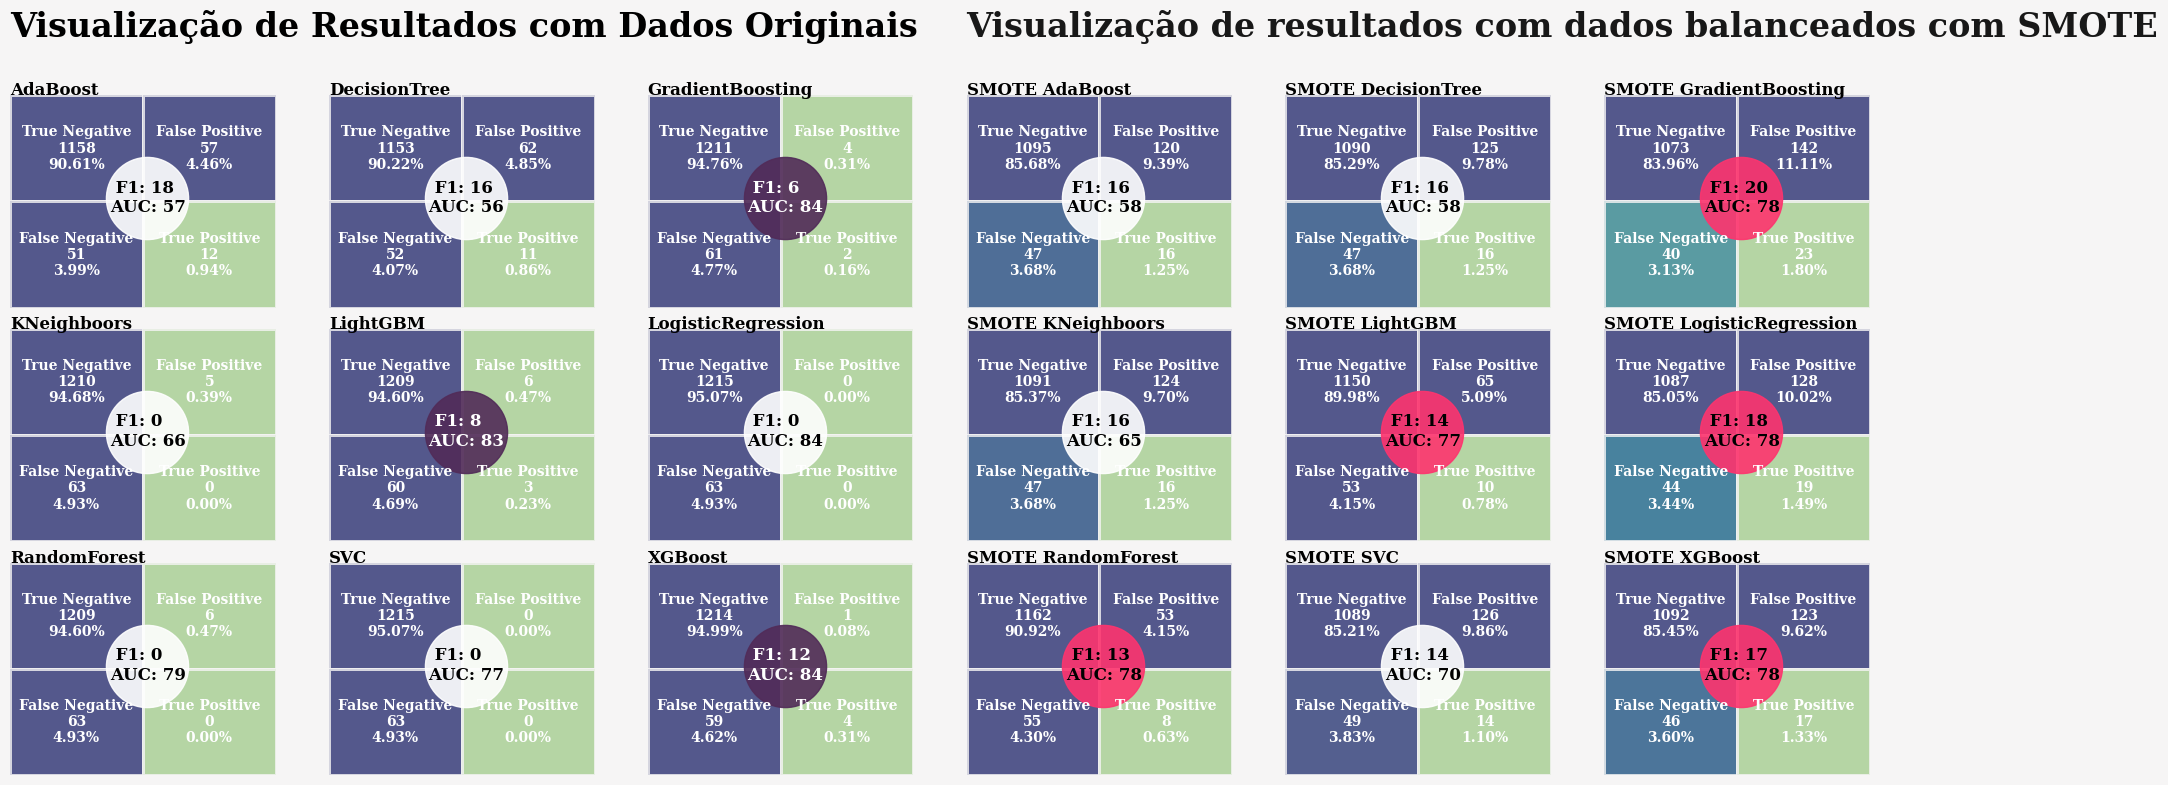

In [507]:
multi_visualize(data = [original_results, resampled_results], vmin=30, vmax=50)

A partir da visualização, fica claro que os dados balanceados com o `SMOTE` apresentaram melhores pontuações de previsão do que os dados originais.

## Conclusão

Porém é nítido um grande problema, visto o número de *True Positive* é muito baixo em todos os casos, e portanto, o modelo não está sendo capaz de prever que a resposta para uma dada amostra quando ela de fato é positiva. Pelo outro lado, o numero de *False Negative* é bem grande, que corre quando o modelo prevê que a resposta para uma dada amostra é negativa e essa predição está errada. Em casos médicos como esse, isso é um grande problema, pois o modelo na maioria das vezes indicaria que a pessoa não está suscetível a ter um AVC quando na verdade ela está. Dessa forma, é importante analisar o problema com mais calma e verficar o por quê disso estar acontecendo.


In [508]:
model = LogisticRegression()
param_grid = {
    'C': [5, 10, 50, 100, 300], 
    'max_iter': [30, 50, 80, 100, 200]
}

In [509]:
log_reg = GridSearchCV(model, param_grid, cv = 5)
log_reg.fit(X_train, y_train)

print(log_reg.best_params_)
log_reg = log_reg.best_estimator_

/home/thiago_lahass/miniconda3/envs/mycondaenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/thiago_lahass/miniconda3/envs/mycondaenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

{'C': 5, 'max_iter': 30}


/home/thiago_lahass/miniconda3/envs/mycondaenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [510]:
score = cross_val_score(log_reg, X_train, y_train, cv = 5, scoring = 'accuracy')
score

/home/thiago_lahass/miniconda3/envs/mycondaenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/thiago_lahass/miniconda3/envs/mycondaenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

array([0.95045632, 0.9517601 , 0.95169713, 0.95169713, 0.95169713])

In [511]:
y_pred = log_reg.predict(X_test)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1215
           1       0.00      0.00      0.00        63

    accuracy                           0.95      1278
   macro avg       0.48      0.50      0.49      1278
weighted avg       0.90      0.95      0.93      1278

0.9507042253521126


/home/thiago_lahass/miniconda3/envs/mycondaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/thiago_lahass/miniconda3/envs/mycondaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/thiago_lahass/miniconda3/envs/mycondaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [512]:
predicted_probab_log = log_reg.predict_proba(X_test)
predicted_probab_log = predicted_probab_log[:, 1]
fpr, tpr, _ = roc_curve(y_test, predicted_probab_log)

auc = roc_auc_score(y_test, predicted_probab_log)

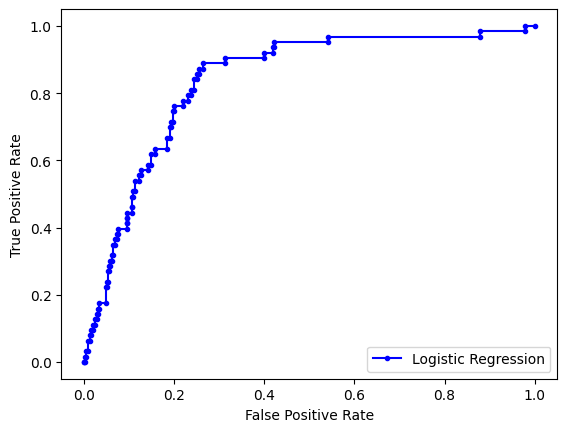

AUC Score:  0.8371284865112025


In [513]:
plt.plot(fpr, tpr, marker = '.', color = 'Blue', label = 'Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')    
plt.legend(loc = 4)
plt.show()
print('AUC Score: ', auc)

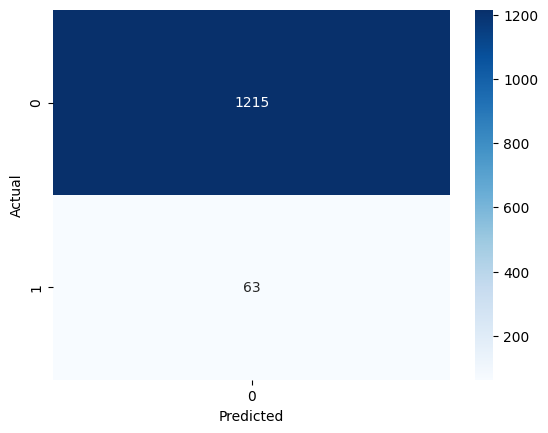

In [514]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames = ['Actual'], colnames = ['Predicted'])
sns.heatmap(confusion_matrix, annot = True, cmap = 'Blues', fmt = 'd')
plt.show()